In [ ]:
# Install TensorFlow
!pip install tensorflow

# Install TQDM for progress display
!pip install tqdm

# Install Pillow for image processing
!pip install pillow

# Install Matplotlib for visualization
!pip install matplotlib

!pip install numpy


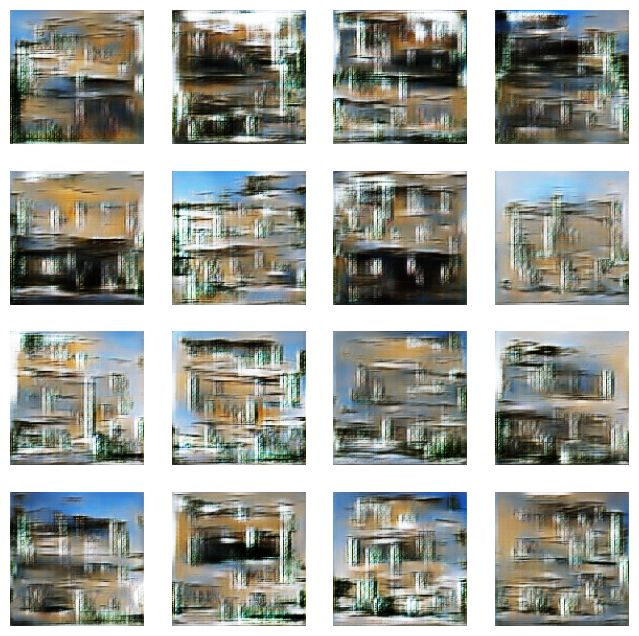

Epoch 600, Generator Loss: 1.2268259525299072, Discriminator Loss: 0.9290332794189453


In [ ]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

# Set the dataset path
dataset_path = '/content/drive/MyDrive/House_Data'  # Update this path to your dataset

# Import necessary libraries
import os
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Check if GPU is available
device_name = tf.test.gpu_device_name()
print(f'Using device: {device_name}' if device_name else 'GPU device not found')

# Define image dimensions and channels
IMG_HEIGHT = 128
IMG_WIDTH = 128
CHANNELS = 3

# Define training parameters
EPOCHS = 5000
BATCH_SIZE = 64
BUFFER_SIZE = 10000
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16
LEARNING_RATE = 1e-4

# Function to load and preprocess images
def load_images(dataset_path):
    image_files = glob(os.path.join(dataset_path, '*'))
    images = []
    for img_file in tqdm(image_files):
        try:
            img = load_img(img_file, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img = img_to_array(img)
            img = (img - 127.5) / 127.5  # Normalize images to [-1, 1]
            images.append(img)
        except Exception as e:
            print(f"Error loading image {img_file}: {e}")
            continue
    images = np.array(images)
    return images

# Load the dataset
images = load_images(dataset_path)
print(f"Loaded {images.shape[0]} images.")

# Prepare the dataset
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Define the Generator model
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 16, 256)))
    assert model.output_shape == (None, 16, 16, 256)

    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(CHANNELS, kernel_size=4, strides=1, padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, CHANNELS)

    return model

# Define the Discriminator model
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, kernel_size=4, strides=2, padding='same', input_shape=[IMG_HEIGHT, IMG_WIDTH, CHANNELS]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Create the Generator and Discriminator
generator = build_generator()
discriminator = build_discriminator()

# Define the loss function and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy()

generator_optimizer = Adam(LEARNING_RATE, beta_1=0.5)
discriminator_optimizer = Adam(LEARNING_RATE, beta_1=0.5)

# Seed for generating images
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

# Define the training functions
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Label smoothing
        real_labels = tf.ones_like(real_output) * 0.9
        fake_labels = tf.zeros_like(fake_output)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss_real = cross_entropy(real_labels, real_output)
        disc_loss_fake = cross_entropy(fake_labels, fake_output)
        disc_loss = disc_loss_real + disc_loss_fake

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Function to generate and save images
import matplotlib.pyplot as plt
from IPython import display

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    predictions = (predictions + 1) / 2.0  # Rescale to [0, 1]

    fig = plt.figure(figsize=(8, 8))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_list.append(gen_loss)
            disc_loss_list.append(disc_loss)

        # Display the progress every 100 epochs
        if (epoch + 1) % 100 == 0:
            display.clear_output(wait=True)
            generate_and_save_images(generator, epoch + 1, seed)
            print(f'Epoch {epoch + 1}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}')

        # Save the model every 500 epochs
        if (epoch + 1) % 500 == 0:
            generator.save_weights(f'generator_epoch_{epoch + 1}.weights.h5')
            discriminator.save_weights(f'discriminator_epoch_{epoch + 1}.weights.h5')
            # Save the entire model
            generator.save(f'generator_epoch_{epoch + 1}.h5')
            discriminator.save(f'discriminator_epoch_{epoch + 1}.h5')

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    # Save the final models
    generator.save_weights('generator_final.weights.h5')
    discriminator.save_weights('discriminator_final.weights.h5')
    generator.save('generator_final.h5')
    discriminator.save('discriminator_final.h5')

# Start training
train(train_dataset, EPOCHS)

# Save the generator model in .pth format for integration
# Convert the Keras model to a PyTorch model (if needed for your web integration)
# Alternatively, use TensorFlow SavedModel format for serving
